# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 16.2 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dtcnduve
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-dtcnduve
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 7.58 MiB/s, done.
Resolving deltas: 100% (3/3), done.


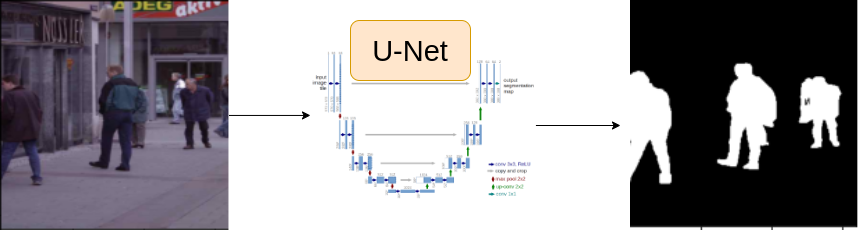

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [44]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE='cuda'

EPOCHS=25
LR=0.003
IMAGE_SIZE=320
BATCH_SIZE=16

ENCODER="timm-efficientnet-b0"
WEIGHTS="imagenet"

In [45]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [46]:
row=df.iloc[0]

image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

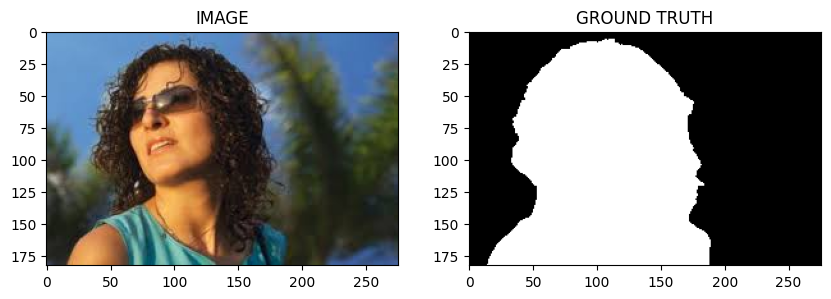

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

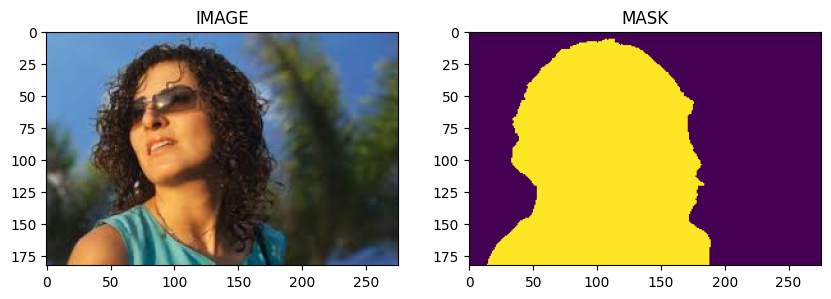

In [48]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [49]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [50]:
import albumentations as A

In [51]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [52]:
from torch.utils.data import Dataset

In [53]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data["image"]
      mask=data["mask"]

    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask

In [54]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_valid_augs())

In [55]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


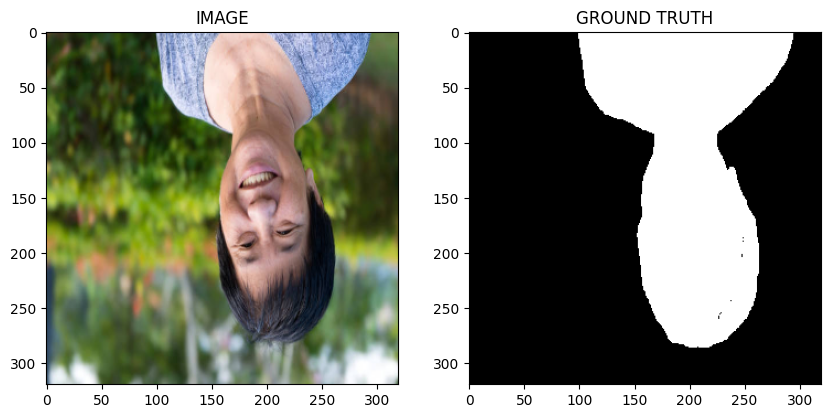

In [56]:
idx=3

image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [57]:
from torch.utils.data import DataLoader

In [58]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [59]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [60]:
for image,mask in trainloader:
  break

print(f"image shape : {image.shape}")
print(f"mask shape : {mask.shape}")

image shape : torch.Size([16, 3, 320, 320])
mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [61]:
!pip install segmentation_models

In [62]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [74]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self,images,masks=None):
    logits=self.arc(images)
    if masks != None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1+loss2
    return logits

In [75]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [76]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0

  for images,masks in tqdm(data_loader):
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(images,masks)

    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)

In [77]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)
      logits,loss=model(images,masks)
      total_loss+=loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [78]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [79]:
best_valid_loss=np.inf

for epoch in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)
  print(f"Epoch : {epoch+1}")
  print(f"Train Loss : {train_loss:.4f}")
  print(f"Valid Loss : {valid_loss:.4f}")
  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),"best_model.pt")
    print("Saved Best Model!")
    best_valid_loss=valid_loss

100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


Epoch : 1
Train Loss : 0.7429
Valid Loss : 0.6090
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  6.32it/s]


Epoch : 2
Train Loss : 0.3613
Valid Loss : 0.5047
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Epoch : 3
Train Loss : 0.3160
Valid Loss : 0.4181
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


Epoch : 4
Train Loss : 0.2618
Valid Loss : 0.2634
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  6.33it/s]


Epoch : 5
Train Loss : 0.3444
Valid Loss : 0.3184


100%|██████████| 4/4 [00:00<00:00,  6.27it/s]


Epoch : 6
Train Loss : 0.2625
Valid Loss : 0.2288
Saved Best Model!


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Epoch : 7
Train Loss : 0.2241
Valid Loss : 0.2329


100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


Epoch : 8
Train Loss : 0.1785
Valid Loss : 0.1798
Saved Best Model!


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


Epoch : 9
Train Loss : 0.1625
Valid Loss : 0.1575
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Epoch : 10
Train Loss : 0.1802
Valid Loss : 0.2226


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch : 11
Train Loss : 0.1659
Valid Loss : 0.1925


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch : 12
Train Loss : 0.1419
Valid Loss : 0.1541
Saved Best Model!


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


Epoch : 13
Train Loss : 0.1530
Valid Loss : 0.2380


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


Epoch : 14
Train Loss : 0.1495
Valid Loss : 0.1999


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch : 15
Train Loss : 0.1361
Valid Loss : 0.1809


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch : 16
Train Loss : 0.1356
Valid Loss : 0.2284


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch : 17
Train Loss : 0.1342
Valid Loss : 0.1738


100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


Epoch : 18
Train Loss : 0.1574
Valid Loss : 0.2118


100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


Epoch : 19
Train Loss : 0.1650
Valid Loss : 0.2367


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


Epoch : 20
Train Loss : 0.1478
Valid Loss : 0.2108


100%|██████████| 4/4 [00:00<00:00,  6.35it/s]


Epoch : 21
Train Loss : 0.1320
Valid Loss : 0.2307


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Epoch : 22
Train Loss : 0.1253
Valid Loss : 0.2137


100%|██████████| 4/4 [00:00<00:00,  6.27it/s]


Epoch : 23
Train Loss : 0.1178
Valid Loss : 0.1854


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch : 24
Train Loss : 0.1172
Valid Loss : 0.1927


100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

Epoch : 25
Train Loss : 0.1065
Valid Loss : 0.1716


# Task 9 : Inference

In [80]:
idx=20

model.load_state_dict(torch.load("best_model.pt"))
image,mask=validset[idx]

logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

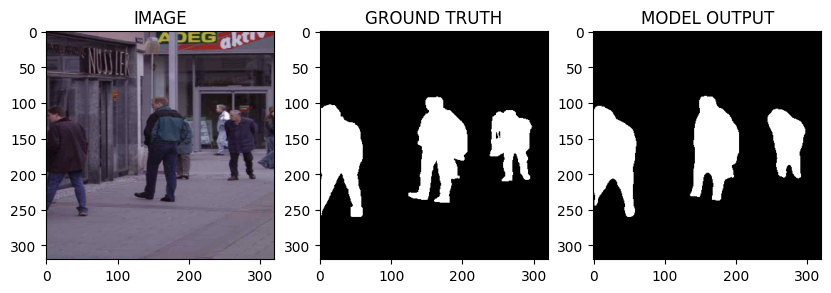

In [82]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))